In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from segmentation.fuzzy_c_means import FuzzyCMeansSegmenter
from filtering.kalman_filter import KalmanFilter
from filtering.lowpass_filter import LowPassFilter
import os

In [2]:
folder_path = "/workspaces/python-opencv/resources/VisDrone2019-SOT-train/sequences/uav0000169_00000_s/"
# folder_path = "/workspaces/python-opencv/resources/VisDrone2019-SOT-train/sequences/uav0000068_03768_s/"
out_path = "/workspaces/python-opencv/repo/out/sequence.mp4"

In [3]:
pictures = sorted(os.listdir(folder_path))
fps = 30

In [4]:
frame = cv.imread(folder_path + pictures[0])

In [5]:
x, y, w, h = 625, 425, 30, 40
# x, y, w, h = 615, 415, 50, 60
# x, y, w, h = 620, 350, 25, 30
# x, y, w, h = 1325, 725, 30, 75
track_window = (x, y, w, h)

inner_window = (int(x + w/4), int(y + h/4), int(w/2), int(h/2))

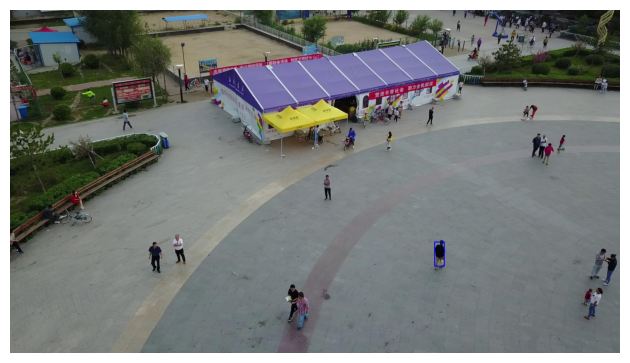

In [6]:
img2 = cv.rectangle(frame, (x, y), (x+w, y+h), 255, 2)

plt.imshow(img2[:, :, ::-1])
plt.axis("off")
plt.tight_layout()
plt.show()

In [7]:
frame = cv.imread(folder_path + pictures[0])

In [8]:
roi = frame[y:y+h, x:x+w, :]

# TODO SUBFRAME

histogram_region = roi
histogram_region_hsv = cv.cvtColor(histogram_region, cv.COLOR_BGR2HSV) 

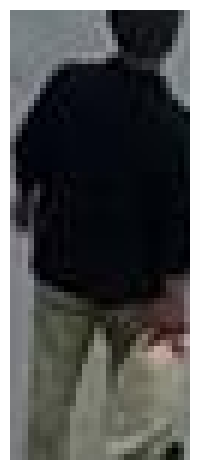

In [9]:
plt.imshow(roi[:, :, ::-1])
plt.axis("off")
plt.tight_layout()
plt.show()

In [10]:
fuzzy = FuzzyCMeansSegmenter(5, 0, 5, 2, 2, 100)
segmented, centroids = fuzzy.segment_image(histogram_region_hsv, return_centroid=True)

subset_segmented = segmented[int(h/4):int(3 * h/4), int(w/4):int(3 * w/4)]
# subset_segmented = segmented

counts = np.bincount(subset_segmented.flatten())
dominant_index = np.argmax(counts)
dominant_color = centroids[dominant_index]

In [11]:
dominant_color

array([110.35988276, 162.7343348 ,  15.53532534])

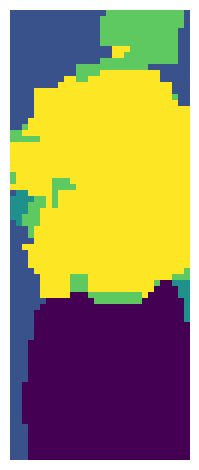

In [12]:
plt.imshow(segmented)
plt.axis("off")
plt.tight_layout()
plt.show()

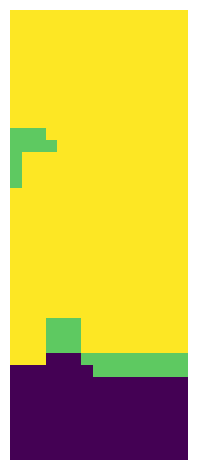

In [13]:
plt.imshow(subset_segmented)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
h, s, v = dominant_color
std_h, std_s, std_v = np.std(roi, axis=(0, 1))

lower_bound = np.array([max(h - std_h, 0), max(s - std_s, 0), max(v - std_v, 0)])
upper_bound = np.array([min(h + std_h, 180), min(s + std_s, 255), min(v + std_v, 255)])

print(lower_bound)
print(upper_bound)

[ 61.95618871 110.36776451   0.        ]
[158.76357682 215.10090509  68.29646802]


In [15]:
hsv_roi = cv.cvtColor(roi, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsv_roi, lower_bound, upper_bound)

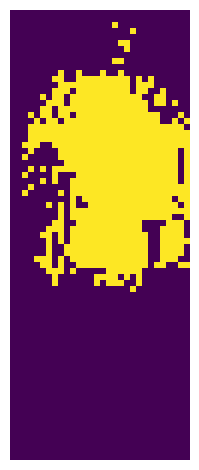

In [16]:
plt.imshow(mask)
plt.axis("off")
plt.tight_layout()
plt.show()

In [17]:
roi_hist = cv.calcHist([hsv_roi], [0], mask, [180], [0, 180])
roi_hist = cv.normalize(roi_hist, roi_hist, 0, 255, cv.NORM_MINMAX)

In [18]:
fourcc = cv.VideoWriter_fourcc(*'mp4v')
video_out = cv.VideoWriter(out_path, fourcc, fps, frame.shape[0:2][::-1]) 

In [19]:
term_crit = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1)

In [20]:
def bbox_to_kalman_state(bbox):
    x = bbox[0] + bbox[2]/2
    y = bbox[1] + bbox[3]/2
    w = bbox[2]
    h = bbox[3]

    return np.array(([x], [y], [w], [h]))

first_obs = bbox_to_kalman_state(track_window)

interlaced = np.zeros((8, 1))
interlaced[::2, :] = first_obs

dt = 1/fps

F = np.identity(8)
F[0, 1] = dt
F[2, 3] = dt
F[4, 5] = dt
F[5, 7] = dt

H = np.zeros((4, 8))
H[0, 0] = 1
H[1, 2] = 1
H[2, 4] = 1
H[3, 6] = 1

Q = np.identity(8) * 0.9

def kalman_state_to_bbox(kalman_state):
    s = H @ kalman_state
    return np.array([s[0] - s[2]/2, s[1] - s[3]/2, s[2], s[3]], dtype=np.int32)

kalman = KalmanFilter(interlaced, F, H, Q=Q)
lowpass = LowPassFilter(first_obs, np.array([[0.1], [0.1], [0.9], [0.9]]))

In [21]:
for picture in pictures:
    frame = cv.imread(folder_path + picture)

    hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    dst = cv.calcBackProject([hsv], [0], roi_hist, [0, 180], 1)

    # apply meanshift to get the new location
    ret, track_window = cv.meanShift(dst, track_window, term_crit)

    kalman_res = kalman_state_to_bbox(kalman.predict(bbox_to_kalman_state(track_window)))
    lowpass_res = np.int_(lowpass.predict(kalman_res))
    track_window = tuple(np.int_(lowpass_res.flatten()))

    # Draw it on image
    x, y, w, h = track_window
    img2 = cv.rectangle(frame, (x, y), (x+w, y+h), 255, 2)
    
    video_out.write(img2)

In [22]:
video_out.release()
cv.destroyAllWindows()